# Goals

We here want to model VPD as a climate hazard, as was done in the following study: https://www.nature.com/articles/s43016-022-00614-8#MOESM1

hazard can be modeled as the mean VPD during the growing season, the vulnerability is given within the paper

the growing season is given for each country inside the study: Mexico is June-December, Guatemala is June-Feb

## Vapour Pressure Deficit (VPD) Calculation

Vapour Pressure Deficit (VPD) quantifies the drying power of the air and is a key factor influencing plant water stress. It represents the difference between the saturation vapour pressure (*es*) and the actual vapour pressure (*ea*).

The steps to calculate VPD are:

1. **Calculate the saturation vapour pressure (es)** from air temperature (*T*, in °C) using the Tetens formula:

   \[
   e_s(T) = 0.6108 \times \exp\left( \frac{17.27 \times T}{T + 237.3} \right)
   \]

2. **Obtain the actual vapour pressure (ea)**:
   - If relative humidity (RH) is available:

     \[
     e_a = \left( \frac{RH}{100} \right) \times e_s
     \]

   - If actual vapour pressure (ea) is directly available (e.g., from climate data), it can be used directly.

3. **Compute the Vapour Pressure Deficit (VPD)**:

   \[
   VPD = e_s - e_a
   \]

**Units:** VPD is typically expressed in kilopascals (kPa).

In this study, we calculate VPD using mean air temperature and actual vapour pressure extracted from WorldClim v2.1 climate data.


## Open questions:
how to we include the agroforestry effect? are those somehow less affected? who knows

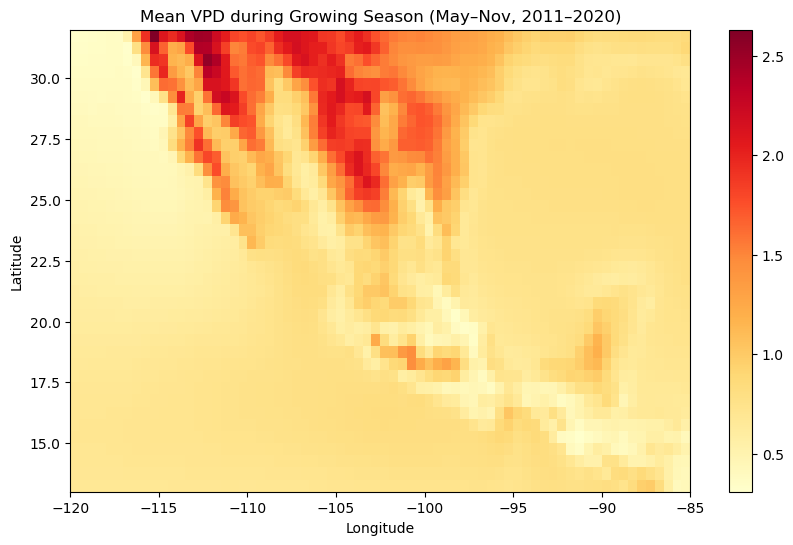

In [36]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
humidity_path = "/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/isimip3a/hurs/20crv3-era5_obsclim_hurs_global_daily_2011_2020.nc"
temperature_path = "/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/isimip3a/tas/20crv3-era5_obsclim_tas_global_daily_2011_2020.nc"

ds_hurs = xr.open_dataset(humidity_path)
ds_tas = xr.open_dataset(temperature_path)

# Assume variable names are 'hurs' and 'tas'
hurs = ds_hurs['hurs']
tas = ds_tas['tas']

# Define bounding box for Mexico and Guatemala
bbox = {
    "lon_min": -120,
    "lon_max": -85,
    "lat_min": 13,
    "lat_max": 32
}

# 🔥 First spatial subset
tas = tas.sel(lat=slice(bbox["lat_max"], bbox["lat_min"]),
              lon=slice(bbox["lon_min"], bbox["lon_max"]))
hurs = hurs.sel(lat=slice(bbox["lat_max"], bbox["lat_min"]),
              lon=slice(bbox["lon_min"], bbox["lon_max"]))

# Convert temperature from Kelvin to Celsius
tas_celsius = tas - 273.15

# Select growing season months (May to November)
growing_season = tas_celsius['time.month'].isin([5, 6, 7, 8, 9, 10, 11])

tas_gs = tas_celsius.sel(time=growing_season)
hurs_gs = hurs.sel(time=growing_season)

# Calculate saturation vapour pressure (es) in kPa
es = 0.6108 * np.exp((17.27 * tas_gs) / (tas_gs + 237.3))

# Calculate actual vapour pressure (ea) in kPa
ea = (hurs_gs / 100) * es

# Calculate VPD
vpd = es - ea

# Now groupby year and average VPD over growing season
vpd_yearly_mean = vpd.groupby('time.year').mean(dim='time')

# Final: average across all years (2011–2020)
vpd_growing_season_mean = vpd_yearly_mean.mean(dim='year')

# Plot
plt.figure(figsize=(10, 6))
vpd_growing_season_mean.plot(cmap="YlOrRd")
plt.title("Mean VPD during Growing Season (May–Nov, 2011–2020)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [50]:
vpd_yearly_mean

<xarray.DataArray (year: 10, lat: 38, lon: 70)> Size: 106kB
array([[[0.3045287 , 0.30522704, 0.30593413, ..., 0.98931307,
         0.98900956, 1.0359585 ],
        [0.32270756, 0.3228469 , 0.3182833 , ..., 0.9763817 ,
         1.0239382 , 1.0968012 ],
        [0.33665413, 0.33551767, 0.3292367 , ..., 0.84941614,
         0.87828404, 0.9500234 ],
        ...,
        [0.6758055 , 0.6826275 , 0.6900067 , ..., 0.5191487 ,
         0.449832  , 0.4473203 ],
        [0.6798222 , 0.68588144, 0.69170487, ..., 0.48176667,
         0.43506512, 0.40321207],
        [0.6839611 , 0.6898361 , 0.6942543 , ..., 0.46855727,
         0.3888857 , 0.41612804]],

       [[0.27877542, 0.29129884, 0.2983404 , ..., 0.8575194 ,
         0.85891664, 0.8954794 ],
        [0.29460463, 0.30622688, 0.31237945, ..., 0.81268525,
         0.848926  , 0.9330383 ],
        [0.3032911 , 0.31449226, 0.31854174, ..., 0.6998123 ,
         0.7483362 , 0.8212108 ],
...
        [0.70341724, 0.7019136 , 0.7014037 , ..., 0.7020551 ,
         0.5506985 , 0.51702625],
        [0.6843686 , 0.68606323, 0.68982506, ..., 0.6712339 ,
         0.5214988 , 0.47137377],
        [0.67329115, 0.67697275, 0.6818662 , ..., 0.68157554,
         0.4611283 , 0.46418676]],

       [[0.32963592, 0.34052113, 0.35013944, ..., 0.8132094 ,
         0.8444101 , 0.89217913],
        [0.35305837, 0.35806185, 0.35763156, ..., 0.7524529 ,
         0.80853844, 0.8920812 ],
        [0.3685893 , 0.36615065, 0.36121586, ..., 0.6784473 ,
         0.7163507 , 0.7785987 ],
        ...,
        [0.6934901 , 0.6871632 , 0.68291247, ..., 0.5251499 ,
         0.45543018, 0.45123932],
        [0.6916808 , 0.68651414, 0.6821086 , ..., 0.51020086,
         0.4426223 , 0.41407105],
        [0.68712664, 0.6864707 , 0.68338734, ..., 0.506887  ,
         0.39102358, 0.4134626 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 560B -119.8 -119.2 -118.8 ... -86.25 -85.75 -85.25
  * lat      (lat) float64 304B 31.75 31.25 30.75 30.25 ... 14.25 13.75 13.25
  * year     (year) int64 80B 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020

In [59]:
vpd_dataset = vpd_yearly_mean.to_dataset(name='vpd')


In [60]:
vpd_dataset = vpd_dataset.rename({"year":"time","lat":"latitude","lon":"longitude"})

In [73]:
from climada.hazard import Hazard
vpd = Hazard.from_xarray_raster(vpd_dataset, intensity='vpd', hazard_type='VPD', intensity_unit='kPA')

2025-04-28 17:41:59,551 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings


In [107]:
vpd.frequency = np.ones(len(vpd.frequency))/

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<GeoAxes: title={'center': 'vpd max intensity at each point'}>

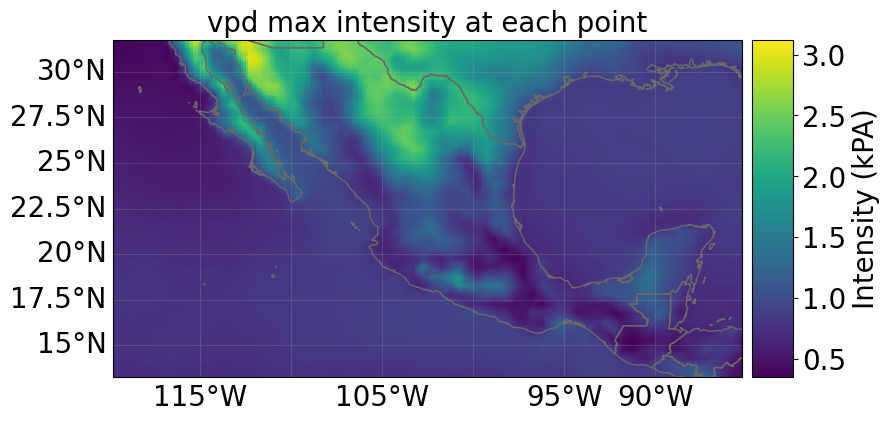

In [65]:
vpd.plot_intensity(0)

<GeoAxes: title={'center': '1-largest Event. ID 1:'}>

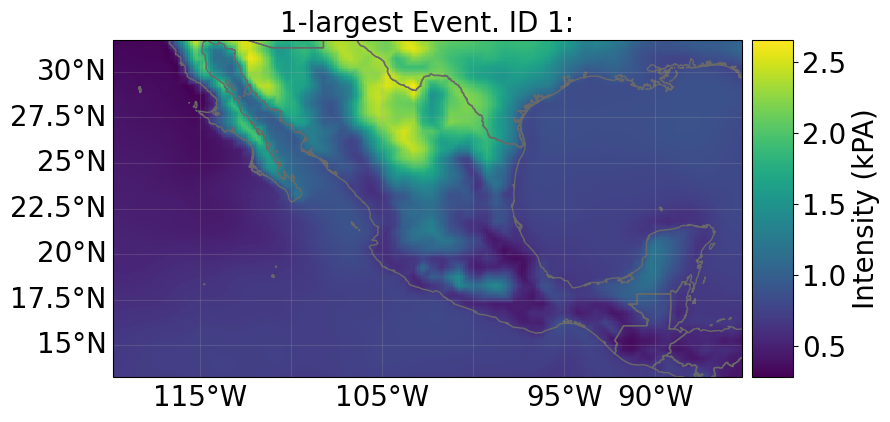

In [67]:
# worst event
vpd.plot_intensity(-1)

next steps: model a couple years, open as climada hazard
open vulnerability data


In [25]:
#data from : https://mapspam.info
from climada.entity import Exposures

exp = Exposures.from_raster("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/UNU_data/dataverse_files/Global_Geotiff/spam2020V1r0_global_yield/spam2020_v1r0_global_Y_COFF_A.tif")

In [74]:
exp.gdf['impf_VPD'] = 1

In [100]:
# Select only exposures inside the bounding box
exp_central_america = exp.gdf[
    (exp.gdf.geometry.x >= bbox["lon_min"]) &
    (exp.gdf.geometry.x <= bbox["lon_max"]) &
    (exp.gdf.geometry.y >= bbox["lat_min"]) &
    (exp.gdf.geometry.y <= bbox["lat_max"])
].copy()

In [94]:
Exposures?

Init signature:
Exposures(
    data=None,
    index=None,
    columns=None,
    dtype=None,
    copy=False,
    geometry=None,
    crs=None,
    meta=None,
    description=None,
    ref_year=None,
    value_unit=None,
    value=None,
    lat=None,
    lon=None,
)
Docstring:     
geopandas GeoDataFrame with metadata and columns (pd.Series) defined in
Attributes.

Attributes
----------
description : str
    metadata - description of content and origin of the data
ref_year : int
    metadata - reference year
value_unit : str
    metadata - unit of the exposures values
data : GeoDataFrame
    containing at least the columns 'geometry' and 'value' for locations and assets
    optionally more, a.o., 'region_id', 'category_id', columns for (hazard specific) assigned
    centroids and (hazard specific) impact funcitons.
Init docstring:
Parameters
----------
data : dict, iterable, DataFrame, GeoDataFrame, ndarray
    data of the initial DataFrame, see ``pandas.DataFrame()``.
    Used to initial

In [101]:
exp_central_america = Exposures(data=exp_central_america)

In [102]:
exp_central_america.gdf

,value,impf_vpd,impf_VPD,centr_VPD,geometry
3007440,0.0,1,1,0,POINT (-119.95833 31.95833)
3007441,0.0,1,1,0,POINT (-119.87500 31.95833)
3007442,0.0,1,1,0,POINT (-119.79167 31.95833)
3007443,0.0,1,1,0,POINT (-119.70833 31.95833)
3007444,0.0,1,1,0,POINT (-119.62500 31.95833)
...,...,...,...,...,...
3988495,0.0,1,1,2659,POINT (-85.37500 13.04167)
3988496,0.0,1,1,2659,POINT (-85.29167 13.04167)
3988497,0.0,1,1,2659,POINT (-85.20833 13.04167)
3988498,0.0,1,1,2659,POINT (-85.12500 13.04167)


vulnerability taken from this figure: https://www.nature.com/articles/s43016-022-00614-8/figures/1

<Axes: title={'center': 'VPD 1: Arabica VPD effect'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>

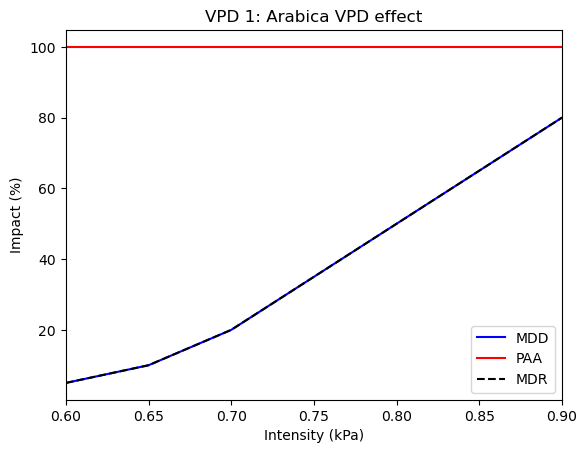

In [76]:
import numpy as np
import pandas as pd
from climada.entity import ImpactFunc

# Load your extracted VPD-effect table
vpd_data = pd.read_csv('vpd_effect_approximation.csv')
vpd_data = vpd_data[vpd_data.Effect_Central<0]
# Extract intensity (VPD) and effect (impact)
vpd_intensity = vpd_data['Mean_VPD_kPa'].values
effect = vpd_data['Effect_Central'].values

# CLIMADA needs MDD (mean damage degree), which must be between 0 and 1
# The "effect" is scaled roughly from -1 to 1 in the original paper figure
# We can map it to MDD: set 0 effect -> 0.5 MDD; -1 -> 1; 1 -> 0 (inverted risk)
mdd = -effect  # simple linear mapping

# Clip to valid range [0,1] just in case
mdd = np.clip(mdd, 0, 1)

# Assume full probability of asset affection (PAA)
paa = np.ones_like(mdd)

# Create the Impact Function
imp_fun_vpd = ImpactFunc(
    id=1,
    name="Arabica VPD effect",
    haz_type="VPD",  # you can define a custom hazard type
    intensity=vpd_intensity,
    mdd=mdd,
    paa=paa,
    intensity_unit="kPa"
)

# Check and plot
imp_fun_vpd.check()
imp_fun_vpd.plot()

In [78]:
# Store the impact function in impact function set
from climada.entity import ImpactFuncSet
# Create an empty ImpactFuncSet
impf_set = ImpactFuncSet()

# add the 2 impact functions into ImpactFuncSet
imp_fun_set = ImpactFuncSet([imp_fun_vpd])

In [103]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp_central_america, imp_fun_set, vpd).impact(
    save_mat=False
)  # Do not save the results geographically resolved (only aggregate values)


2025-04-28 17:48:19,239 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.


<Axes: title={'center': 'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (USD)'>

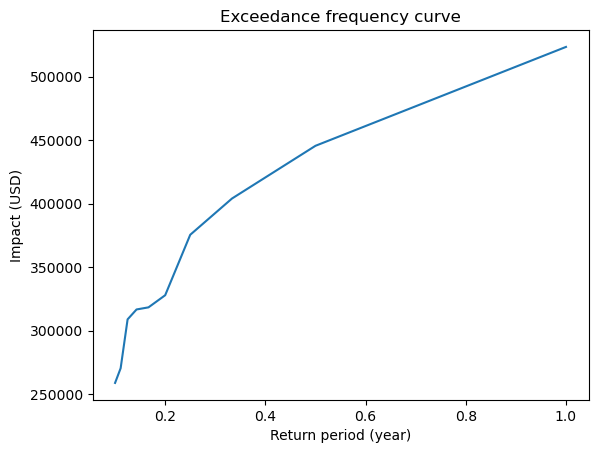

In [105]:
imp.calc_freq_curve().plot()